In [1]:
import argparse
import os
import time

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import jax
from jax import vmap
import jax.numpy as jnp
import jax.random as random

import numpyro
import numpyro.distributions as dist
from numpyro.infer import (
    MCMC,
    NUTS,
    init_to_feasible,
    init_to_median,
    init_to_sample,
    init_to_uniform,
    init_to_value,
)

from tinygp import kernels, GaussianProcess

from models import model, anova_model, run_inference, run_inference_anova


jax.config.update("jax_enable_x64", True)

/Users/jerome/miniconda3/envs/spatGP/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Test GP 1D

<Axes: >

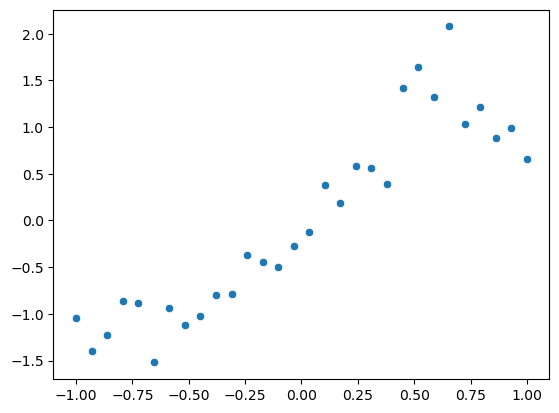

In [2]:
# test data

N = 30
sigma_obs = 0.15
N_test = 400

def y_func(X_pred):
    return(X_pred + 0.2 * jnp.power(X_pred, 2.0) + 0.5 * jnp.power(0.5 + X_pred, 2.0) * jnp.sin(4.0 * X_pred))
    

np.random.seed(0)
X = jnp.linspace(-1, 1, N)
X_pred = jnp.linspace(-1.3, 1.3, N_test)
Y_true = y_func(X_pred)
Y_true -= jnp.mean(Y_true)
Y_true /= jnp.std(Y_true)

Y = y_func(X)
Y += sigma_obs * np.random.randn(N)
Y -= jnp.mean(Y)
Y /= jnp.std(Y)

assert X.shape == (N,)
assert Y.shape == (N,)

sns.scatterplot(x=X,y=Y)


In [3]:
args = {
    'num_samples': 1000,
    'num_warmup': 1000,
    'num_chains': 1,
    'thinning': 2,
    'device': 'cpu',
    'init_strategy': 'median'
}

# do inference
rng_key, rng_key_predict = random.split(random.PRNGKey(0))
samples = run_inference(model, args, rng_key, X, Y, X_pred)


sample: 100%|██████████| 2000/2000 [00:01<00:00, 1148.18it/s, 3 steps of size 4.54e-01. acc. prob=0.95]



                     mean       std    median      5.0%     95.0%     n_eff     r_hat
  kernel_length      0.53      0.17      0.50      0.30      0.83    399.40      1.00
   kernel_noise      0.08      0.02      0.08      0.05      0.12    440.72      1.00
     kernel_var      1.94      2.86      1.06      0.19      4.53    322.62      1.00

Number of divergences: 0

MCMC elapsed time: 3.5106348991394043


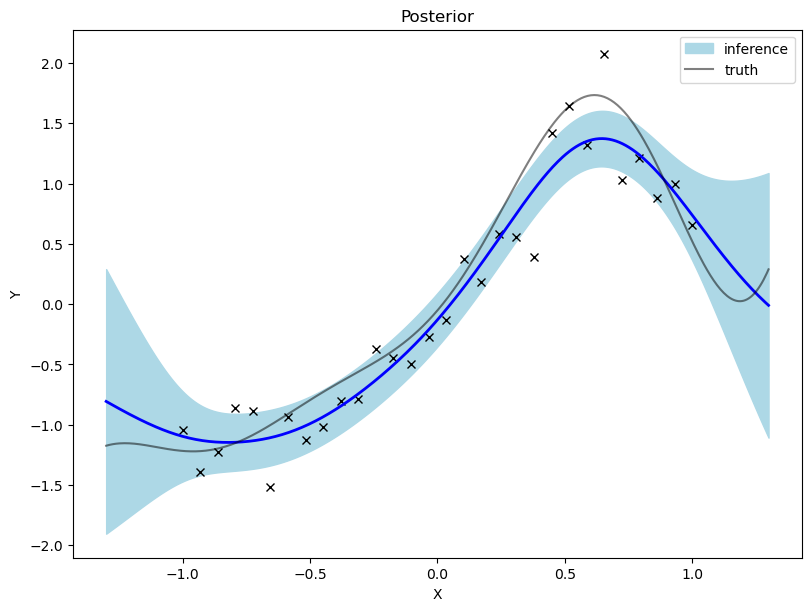

In [4]:
posterior_means = np.mean(samples["pred"][0], axis=0)
vars = np.mean(samples["pred"][1], axis=0) # (maybe sus, TODO: check later)
lower = posterior_means - 2*jnp.sqrt(vars) # 2* std dev ~ 95 CI
upper = posterior_means + 2*jnp.sqrt(vars)

fig, ax = plt.subplots(figsize=(8, 6), constrained_layout=True)
# plot training data
ax.plot(X, Y, "kx")
# plot 90% confidence level of predictions
ax.fill_between(X_pred, lower, upper, color="lightblue", label='inference')
# plot mean prediction
ax.plot(X_pred, posterior_means, "blue", ls="solid", lw=2.0)
# plot truth
ax.plot(X_pred, Y_true, "k", lw=1.5, alpha=0.5, label="truth")
ax.set(xlabel="X", ylabel="Y", title="Posterior")
plt.legend()

## Simulate 2D data

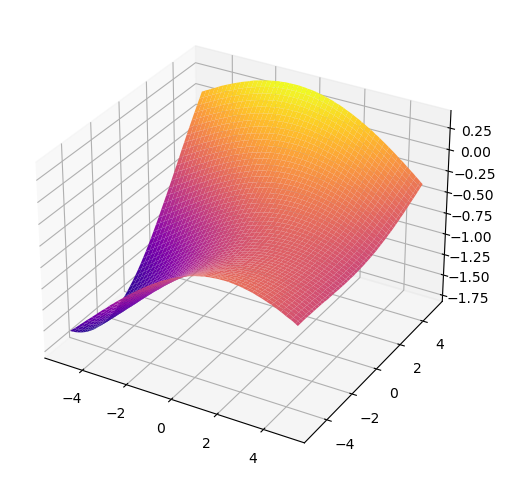

In [5]:
# simulate 2d data from GP

from scipy.stats import multivariate_normal, uniform
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm

x_grid, y_grid = jnp.linspace(-5, 5, 100), np.linspace(-5, 5, 50)
x_2d, y_2d = jnp.meshgrid(x_grid, y_grid)
X_true = jnp.vstack((x_2d.flatten(), y_2d.flatten())).T

kernel = 2*kernels.ExpSquared(scale=8)
gp = GaussianProcess(kernel, X_true, diag=1e-6)
Y_true = gp.sample(jax.random.PRNGKey(4), shape=(1,))


fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')

Y_reshape = jnp.reshape(Y_true, (50,100))
ax.plot_surface(x_2d, y_2d, Y_reshape, cmap=cm.plasma)

plt.show()

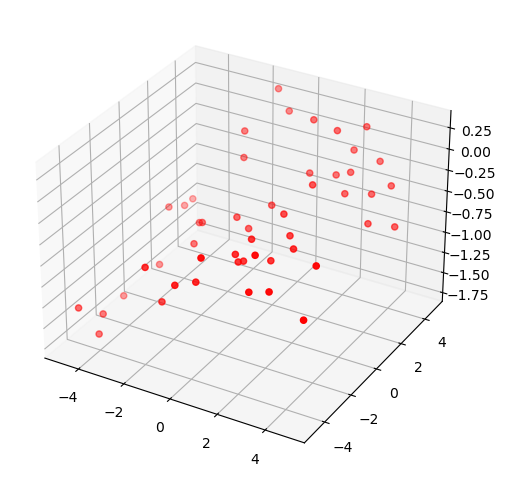

In [7]:
N = 50
sigma_obs = 0.15

np.random.seed(0)
obs_indices = np.random.choice(np.arange(0, X_true.shape[0]), size=N, replace=False)
X = X_true[obs_indices,:]
Y = Y_true.T[:,0][obs_indices]
Y += sigma_obs * np.random.randn(N)

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:,0], X[:,1], Y, c='red')


In [8]:
samples = run_inference(model, args, rng_key, X, Y, X_true)

sample: 100%|██████████| 2000/2000 [00:04<00:00, 478.50it/s, 1 steps of size 3.60e-01. acc. prob=0.95] 



                     mean       std    median      5.0%     95.0%     n_eff     r_hat
  kernel_length      6.74      2.11      6.26      3.76      9.89    302.98      1.00
   kernel_noise      0.02      0.01      0.02      0.02      0.03    378.69      1.00
     kernel_var      2.29      3.63      1.24      0.17      4.80    243.13      1.00

Number of divergences: 0

MCMC elapsed time: 5.888978958129883


<Figure size 800x600 with 0 Axes>

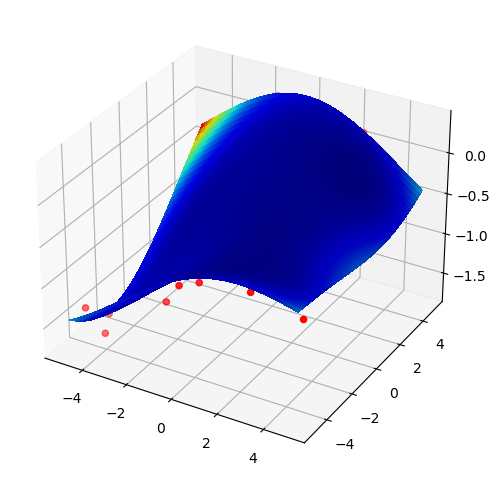

In [10]:
post_means = np.mean(samples["pred"][0], axis=0)
post_vars = np.mean(samples["pred"][1], axis=0)
post_means.shape

fig = plt.figure(figsize=(8,6))
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')


post_means_reshape = jnp.reshape(post_means, (50,100))
post_vars_reshape = jnp.reshape(post_vars, (50,100))
# ax.plot_surface(x_2d, y_2d, post_means_reshape, cmap=cm.plasma)
ax.plot_surface(x_2d, y_2d, post_means_reshape,rstride=1, cstride=1, facecolors = cm.jet(post_vars_reshape/np.amax(post_vars_reshape)),linewidth=0, antialiased=False)
ax.scatter(X[:,0], X[:,1], Y, c='red')
# ax.view_init(15, -75)

plt.show()

## Run ANOVA model

In [11]:
# run on previous data w/ no factors in generative model
args = {
    'num_samples': 1000,
    'num_warmup': 1000,
    'num_chains': 1,
    'thinning': 2,
    'device': 'cpu',
    'init_strategy': 'median'
}

# do inference
rng_key, rng_key_predict = random.split(random.PRNGKey(0))

X_factor = np.tile(np.array([1.0,2.0]), int(X.shape[0]/2))
factors = np.unique(X_factor)
samples = run_inference_anova(anova_model, args, rng_key, X, X_factor, Y, X_true, factors)

sample: 100%|██████████| 2000/2000 [03:08<00:00, 10.60it/s, 511 steps of size 5.64e-03. acc. prob=0.95] 



                   mean       std    median      5.0%     95.0%     n_eff     r_hat
 alpha_1.0[0]      0.00      0.00     -0.00     -0.00      0.01    509.62      1.00
 alpha_1.0[1]     -0.00      0.00     -0.00     -0.01      0.01    420.04      1.00
 alpha_1.0[2]     -0.00      0.00      0.00     -0.00      0.01    386.93      1.00
 alpha_1.0[3]      0.00      0.00      0.00     -0.00      0.01    396.59      1.00
 alpha_1.0[4]     -0.00      0.00     -0.00     -0.00      0.01    371.87      1.00
 alpha_1.0[5]     -0.00      0.00     -0.00     -0.01      0.01    353.14      1.00
 alpha_1.0[6]     -0.00      0.00     -0.00     -0.00      0.01    347.28      1.00
 alpha_1.0[7]     -0.00      0.00     -0.00     -0.01      0.00    387.17      1.00
 alpha_1.0[8]      0.00      0.00     -0.00     -0.00      0.01    426.86      1.00
 alpha_1.0[9]      0.00      0.00      0.00     -0.01      0.00    418.44      1.00
alpha_1.0[10]      0.00      0.00      0.00     -0.00      0.01    427.56  

In [30]:
import pandas as pd
df = []
for key in samples.keys():
    row = [key, np.round(np.mean(samples[key]),2), np.round(np.std(samples[key]),2)]
    df.append(row)

print(pd.DataFrame(df, columns=["param", "mean", "std"]))

        param   mean   std
0   alpha_1.0   -0.0   0.0
1   alpha_2.0    0.0   0.0
2      beta_0  -0.56  0.08
3          mu  -0.56  0.08
4        pred   0.03  0.31
5   rho_alpha   1.01  0.97
6     rho_eps   1.42  0.11
7      rho_mu   0.96  0.99
8   var_alpha    0.0   0.0
9     var_eps   0.18  0.04
10     var_mu    0.0   0.0


<Figure size 800x600 with 0 Axes>

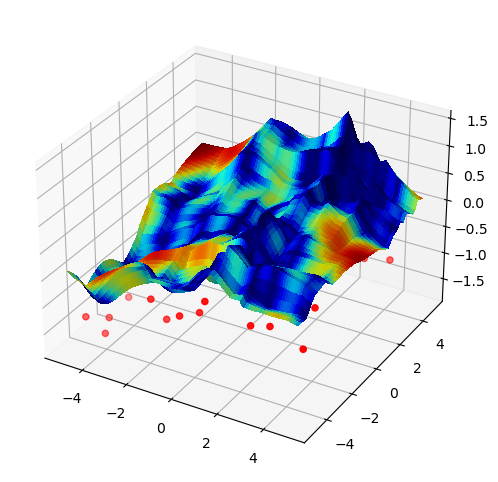

In [12]:
post_means = np.mean(samples["pred"][0], axis=0)
post_vars = np.mean(samples["pred"][1], axis=0)

fig = plt.figure(figsize=(8,6))
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')


post_means_reshape = jnp.reshape(post_means, (50,100))
post_vars_reshape = jnp.reshape(post_vars, (50,100))
# ax.plot_surface(x_2d, y_2d, post_means_reshape, cmap=cm.plasma)
ax.plot_surface(x_2d, y_2d, post_means_reshape,rstride=1, cstride=1, facecolors = cm.jet(post_vars_reshape/np.amax(post_vars_reshape)),linewidth=0, antialiased=False)
ax.scatter(X[:,0], X[:,1], Y, c='red')
# ax.view_init(15, -75)

plt.show()

## Simulate with factor deviations

In [84]:
Beta_0 = 0.1
mu_gp = GaussianProcess(mu_kernel, X_true, diag=1e-5, mean=Beta_0)
mu = mu_gp.sample(jax.random.PRNGKey(4), shape=(1,))
mu

Array([[-0.24502565, -0.21672953, -0.20835457, ..., -0.19722859,
        -0.21379185, -0.2282736 ]], dtype=float64)

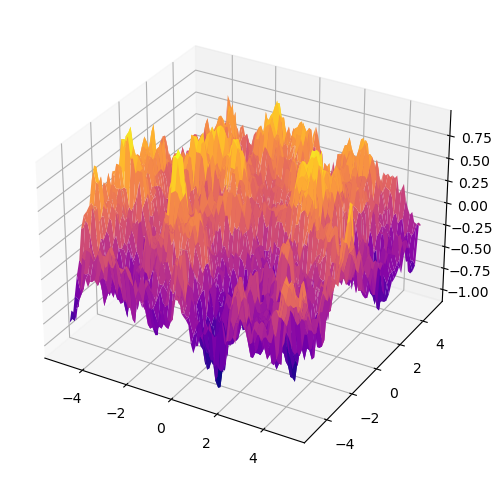

In [85]:
# define factor GP w/ 2 cell types

from scipy.stats import multivariate_normal, uniform
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm

from tinygp.kernels.distance import Distance, L1Distance, L2Distance

x_grid, y_grid = jnp.linspace(-5, 5, 100), np.linspace(-5, 5, 50)
x_2d, y_2d = jnp.meshgrid(x_grid, y_grid)
X_true = jnp.vstack((x_2d.flatten(), y_2d.flatten())).T

factors = [1.0, 2.0]
X_factor_true = np.tile(np.array([1.0,2.0]), int(X_true.shape[0]/2))

var_mu = 0.1
var_alpha = 0.05
var_eps = 0.01

mu_kernel = var_mu*kernels.Matern32(3, distance=L2Distance())

Beta_0 = 0.1
mu_gp = GaussianProcess(mu_kernel, X_true, diag=1e-5, mean=Beta_0)
mu = mu_gp.sample(jax.random.PRNGKey(4), shape=(1,))

rho_alpha = 0.5
alpha_kernel = var_alpha*kernels.Matern32(rho_alpha, distance=L2Distance())
rho_eps = 0.2
eps_kernel = var_eps*kernels.Matern32(rho_eps, distance=L2Distance())
for l in factors:
    alpha_gp = GaussianProcess(alpha_kernel, X_true[X_factor_true==l,:], diag=1e-5, mean=0.0)
    # alpha_l = alpha_gp.sample(jax.random.PRNGKey(4), shape=(int(N_samples/2),))
    alpha_l = alpha_gp.sample(jax.random.PRNGKey(4), shape=(1,))
    # alpha_l = numpyro.sample("alpha_"+str(l), alpha_gp.numpyro_dist())
    mu = mu.at[:,X_factor_true==l].set(mu[:,X_factor_true==l] + alpha_l)

Y_gp = GaussianProcess(eps_kernel, X_true, diag=1e-5, mean_value=mu.T[:,0])
Y_true = Y_gp.sample(jax.random.PRNGKey(4), shape=(1,))
# Y_true = Y_gp.sample(jax.random.PRNGKey(4), shape=(N_samples,))

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')

Y_reshape = jnp.reshape(Y_true, (50,100))
ax.plot_surface(x_2d, y_2d, Y_reshape, cmap=cm.plasma)

plt.show()

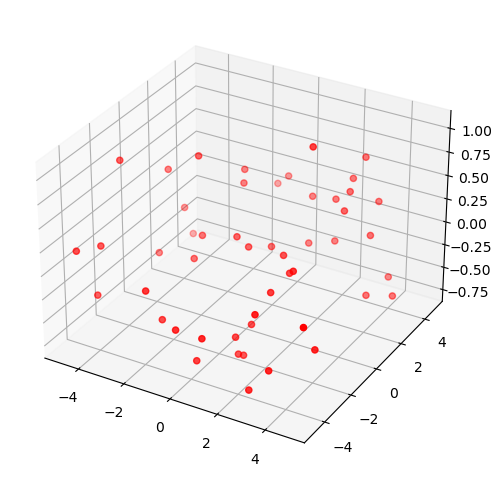

In [86]:
# draw samples
N = 50
sigma_obs = 0.15

np.random.seed(0)
obs_indices = np.random.choice(np.arange(0, X_true.shape[0]), size=N, replace=False)
X = X_true[obs_indices,:]
X_factor = X_factor_true[obs_indices]
Y = Y_true.T[:,0][obs_indices]
Y += sigma_obs * np.random.randn(N)

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:,0], X[:,1], Y, c='red')

In [87]:
# fit normal GP
rng_key, rng_key_predict = random.split(random.PRNGKey(0))

samples = run_inference(model, args, rng_key, X, Y, X_true)

sample: 100%|██████████| 2000/2000 [00:05<00:00, 351.96it/s, 31 steps of size 2.39e-01. acc. prob=0.89]



                     mean       std    median      5.0%     95.0%     n_eff     r_hat
  kernel_length      0.55      0.10      0.55      0.39      0.72    205.15      1.00
   kernel_noise      0.00      0.01      0.00      0.00      0.01    264.80      1.00
     kernel_var      0.15      0.04      0.15      0.09      0.20    260.22      1.00

Number of divergences: 2

MCMC elapsed time: 7.391525030136108


<Figure size 800x600 with 0 Axes>

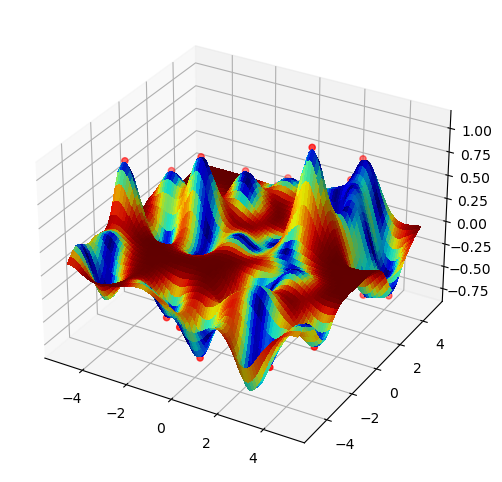

In [88]:
post_means = np.mean(samples["pred"][0], axis=0)
post_vars = np.mean(samples["pred"][1], axis=0)
post_means.shape

fig = plt.figure(figsize=(8,6))
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')

post_means_reshape = jnp.reshape(post_means, (50,100))
post_vars_reshape = jnp.reshape(post_vars, (50,100))
# ax.plot_surface(x_2d, y_2d, post_means_reshape, cmap=cm.plasma)
ax.plot_surface(x_2d, y_2d, post_means_reshape,rstride=1, cstride=1, facecolors = cm.jet(post_vars_reshape/np.amax(post_vars_reshape)),linewidth=0, antialiased=False)
ax.scatter(X[:,0], X[:,1], Y, c='red')
# ax.view_init(15, -75)

plt.show()

In [107]:
from tinygp.kernels.distance import Distance, L1Distance, L2Distance

def anova_model(X, X_factor, Y, X_pred, factors):
    var_mu = numpyro.sample("var_mu", dist.Gamma(0.01, 0.01)) # change to unif if not working
    var_alpha = numpyro.sample("var_alpha", dist.Gamma(0.01, 0.01)) # change to unif if not working
    var_eps = numpyro.sample("var_eps", dist.Gamma(0.01, 0.01)) # change to unif if not working

    rho_mu = numpyro.sample("rho_mu", dist.Gamma(1, 1))
    Beta_0 = numpyro.sample("beta_0", dist.Normal(0,1))
    # Beta_1 = numpyro.sample("beta_1", dist.Normal(0,1))
    # Beta_2 = numpyro.sample("beta_2", dist.Normal(0,1))
    # mu_mean = Beta_0 * jnp.ones(X.shape[0]) + Beta_1 * X[:,0] + Beta_2 * X[:, 1] # assuming coordinates are first two cols
    mu_kernel = var_mu*kernels.Matern32(rho_mu, distance=L2Distance())
    mu_gp = GaussianProcess(mu_kernel, X, diag=1e-5, mean=Beta_0)
    # mu_gp = GaussianProcess(mu_kernel, X, diag=1e-5, mean_value=mu_mean)
    mu = numpyro.sample("mu", mu_gp.numpyro_dist())

    rho_alpha = numpyro.sample("rho_alpha", dist.Gamma(1, 1))
    alpha_kernel = var_alpha*kernels.Matern32(rho_alpha, distance=L2Distance())
    rho_eps = numpyro.sample("rho_eps", dist.Gamma(1, 1))
    eps_kernel = var_eps*kernels.Matern32(rho_eps, distance=L2Distance())
    alpha_l_total = jnp.zeros(mu.shape)
    for l in factors:
        alpha_gp = GaussianProcess(alpha_kernel, X[X_factor==l,:], diag=1e-5, mean=0.0)
        alpha_l = numpyro.sample("alpha_"+str(l), alpha_gp.numpyro_dist())
        alpha_l_total = alpha_l_total.at[X_factor==l].set(alpha_l)
        # mu = mu.at[X_factor==l].set(mu[X_factor==l] + alpha_l) 

    alpha_l_total = alpha_l_total - alpha_l_total.mean() # sum to zero constraint
    mu = mu + alpha_l_total

    Y_gp = GaussianProcess(eps_kernel, X, diag=1e-5, mean_value=mu)
    numpyro.sample("obs", Y_gp.numpyro_dist(), obs=Y)
    numpyro.deterministic("pred", Y_gp.predict(Y, X_pred, return_var=True))



In [108]:
# fit ANOVA GP

rng_key, rng_key_predict = random.split(random.PRNGKey(0))

samples = run_inference_anova(anova_model, args, rng_key, X, X_factor, Y, X_true, factors)

sample: 100%|██████████| 2000/2000 [03:23<00:00,  9.85it/s, 511 steps of size 5.44e-03. acc. prob=0.96] 



                   mean       std    median      5.0%     95.0%     n_eff     r_hat
 alpha_1.0[0]      0.00      0.00     -0.00     -0.00      0.01    541.85      1.00
 alpha_1.0[1]     -0.00      0.00     -0.00     -0.01      0.00    439.04      1.00
 alpha_1.0[2]     -0.00      0.00      0.00     -0.00      0.01    452.14      1.00
 alpha_1.0[3]      0.00      0.00      0.00     -0.01      0.00    443.77      1.00
 alpha_1.0[4]     -0.00      0.00     -0.00     -0.01      0.00    411.06      1.00
 alpha_1.0[5]      0.00      0.00      0.00     -0.01      0.01    386.77      1.00
 alpha_1.0[6]      0.00      0.00      0.00     -0.00      0.01    331.04      1.00
 alpha_1.0[7]     -0.00      0.00     -0.00     -0.01      0.00    411.25      1.00
 alpha_1.0[8]     -0.00      0.00      0.00     -0.01      0.00    366.71      1.00
 alpha_1.0[9]      0.00      0.00      0.00     -0.01      0.00    415.36      1.00
alpha_1.0[10]      0.00      0.00      0.00     -0.00      0.01    487.71  

In [109]:
df = []
for key in samples.keys():
    row = [key, np.round(np.mean(samples[key]),2), np.round(np.std(samples[key]),2)]
    df.append(row)

print(pd.DataFrame(df, columns=["param", "mean", "std"]))

        param  mean   std
0   alpha_1.0  -0.0   0.0
1   alpha_2.0  -0.0   0.0
2      beta_0  0.02  0.07
3          mu  0.02  0.07
4        pred  0.04  0.19
5   rho_alpha  1.05  1.02
6     rho_eps  0.78  0.18
7      rho_mu  1.05  1.05
8   var_alpha   0.0   0.0
9     var_eps  0.18  0.04
10     var_mu   0.0   0.0


<Figure size 800x600 with 0 Axes>

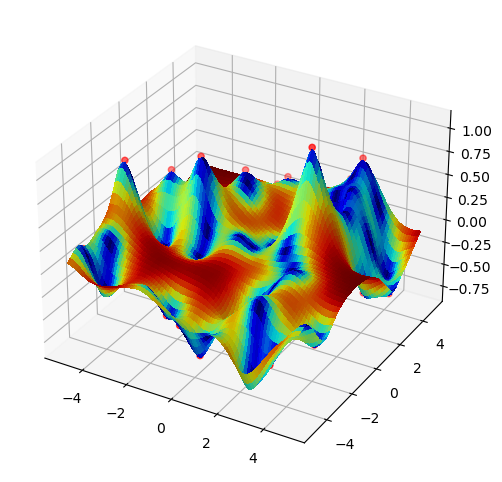

In [110]:
post_means = np.mean(samples["pred"][0], axis=0)
post_vars = np.mean(samples["pred"][1], axis=0)

fig = plt.figure(figsize=(8,6))
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')


post_means_reshape = jnp.reshape(post_means, (50,100))
post_vars_reshape = jnp.reshape(post_vars, (50,100))
# ax.plot_surface(x_2d, y_2d, post_means_reshape, cmap=cm.plasma)
ax.plot_surface(x_2d, y_2d, post_means_reshape,rstride=1, cstride=1, facecolors = cm.jet(post_vars_reshape/np.amax(post_vars_reshape)),linewidth=0, antialiased=False)
ax.scatter(X[:,0], X[:,1], Y, c='red')
# ax.view_init(15, -75)

plt.show()